## 标签

In [1]:
import numpy as np

y_true = np.load('data/test_y.npy')
ids = np.load('data/test_id.npy')

print(len(y_true), y_true[0:10])
print(len(ids), ids[0:10])

1586 [0 0 0 0 1 0 0 0 0 0]
1586 [17148201 17148202 17148203 17148204 17148205 17148206 17148207 17148208
 17148209 17148210]


## 评估

In [2]:
def show(scoreFile):
    y = []
    with open(scoreFile, 'r') as f:
        for line in f.readlines():
            pro = line.strip().split(',')
            y.append(float(pro[1]))
    
    num = 0
    for i in range(len(y_true)):
        if y_true[i] == 0 and y[i] < 0.5: num += 1
        if y_true[i] == 1 and y[i] >= 0.5: num += 1
    score = num / len(y_true)
    
    print('%d / %d = %f' % (num, len(y_true), score))
    return y, score

In [3]:
predictFile1 = 'predict/FastText.txt'
predictFile2 = 'predict/CNN1.txt'
predictFile3 = 'predict/CNN2.txt'
predictFile4 = 'predict/BiLSTM.txt'
predictFile5 = 'predict/Attention.txt'

y1, score1 = show(predictFile1)
y2, score2 = show(predictFile2)
y3, score3 = show(predictFile3)
y4, score4 = show(predictFile4)
y5, score5 = show(predictFile5)

1151 / 1586 = 0.725725
1222 / 1586 = 0.770492
1225 / 1586 = 0.772383
1229 / 1586 = 0.774905
1231 / 1586 = 0.776166


In [4]:
from sklearn.metrics import classification_report, f1_score

def report_(y_true, y_pred):
    yy = [1 if y > 0.5 else 0 for y in y_pred]
    print(classification_report(y_true, yy))

def report(y_true, y_pred):
    yy = [1 if y > 0.5 else 0 for y in y_pred]
    f1 = f1_score(y_true, yy, pos_label=1)
    print(f1)
    return f1

f11 = report(y_true, y1)
f12 = report(y_true, y2)
f13 = report(y_true, y3)
f14 = report(y_true, y4)
f15 = report(y_true, y5)

0.2809917355371901
0.5767441860465116
0.4922644163150492
0.5393548387096774
0.49358059914407987


### 可视化对比

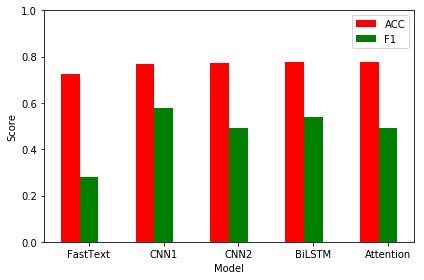

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

name_list = ['FastText', 'CNN1', 'CNN2', 'BiLSTM', 'Attention']
score_list = [score1, score2, score3, score4, score5]
f1_list = [f11, f12, f13, f14, f15]

# 设置柱状图
bar_width = 0.25
index = np.arange(len(name_list))
bar1 = plt.bar(index + bar_width * 0, score_list, bar_width, color='r', label='ACC')
bar2 = plt.bar(index + bar_width * 1, f1_list, bar_width, color='g', label='F1')
plt.xlabel('Model')
plt.ylabel('Score')
plt.xticks(index + bar_width, name_list)
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.savefig('img/Score1.png')
plt.show()

### 模型融合 - 投票

In [6]:
num = 0
predictFile = 'predict/Vote.txt'
y = []
for i in range(len(y_true)):
    t = 0
    f = 0
    if y1[i] > 0.5: t += 1
    else: f += 1
    if y2[i] > 0.5: t += 1
    else: f += 1
    if y3[i] > 0.5: t += 1
    else: f += 1
    if y4[i] > 0.5: t += 1
    else: f += 1
    if y5[i] > 0.5: t += 1
    else: f += 1
    if (y_true[i] == 1 and t >= 3) or (y_true[i] == 0 and f >= 3):
        num += 1
    if t >= 3:
        y.append(1)
    if f >= 3:
        y.append(0)

with open(predictFile, 'w') as f:
    for i in range(len(ids)):
        f.write('%d,%s\n' % (ids[i], y[i]))

score6 = num / len(y_true)
print('%d / %d = %f' % (num, len(y_true), score6))

1249 / 1586 = 0.787516


In [7]:
f16 = report(y_true, y)

0.5051395007342144


### 模型融合 - 平均 (1:1:1:1:1)

In [8]:
num = 0
predictFile = 'predict/Average.txt'
y = []
for i in range(len(y_true)):
    pred = y1[i] + y2[i] + y3[i] + y4[i] + y5[i]
    pred /= 5.0
    if (y_true[i] == 0 and pred <= 0.5) or (y_true[i] == 1 and pred > 0.5):
        num += 1
    if pred > 0.5:
        y.append(1)
    else:
        y.append(0)

with open(predictFile, 'w') as f:
    for i in range(len(ids)):
        f.write('%d,%s\n' % (ids[i], y[i]))

score7 = num / len(y_true)
print('%d / %d = %f' % (num, len(y_true), score7))

1245 / 1586 = 0.784994


In [9]:
f17 = report(y_true, y)

0.49926578560939794


### 模型融合 - 权重 (1:2:2:2:3)

In [10]:
num = 0
predictFile = 'predict/Weight.txt'
y = []
for i in range(len(y_true)):
    pred = y1[i] + 2 * y2[i] + 2 * y3[i] + 2 * y4[i] + 3 * y5[i]
    pred /= 10.0
    if (y_true[i] == 0 and pred <= 0.5) or (y_true[i] == 1 and pred > 0.5):
        num += 1
    if pred > 0.5:
        y.append(1)
    else:
        y.append(0)

with open(predictFile, 'w') as f:
    for i in range(len(ids)):
        f.write('%d,%s\n' % (ids[i], y[i]))

score8 = num / len(y_true)
print('%d / %d = %f' % (num, len(y_true), score8))

1250 / 1586 = 0.788146


In [11]:
f18 = report(y_true, y)

0.5073313782991203


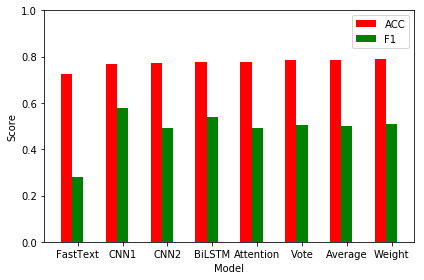

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

name_list = ['FastText', 'CNN1', 'CNN2', 'BiLSTM', 'Attention', 'Vote', 'Average', 'Weight']
score_list = [score1, score2, score3, score4, score5, score6, score7, score8]
f1_list = [f11, f12, f13, f14, f15, f16, f17, f18]

# 设置柱状图
index = np.arange(len(name_list))
bar1 = plt.bar(index + bar_width * 0, score_list, bar_width, color='r', label='ACC')
bar2 = plt.bar(index + bar_width * 1, f1_list, bar_width, color='g', label='F1')
plt.xlabel('Model')
plt.ylabel('Score')
plt.xticks(index + bar_width, name_list)
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.savefig('img/Score2.png')
plt.show()

### MRR MAP TOP-1
![alt text](img/mrr.jpg "title")
![alt text](img/map.jpg "title")

In [13]:
import json

with open('data/test_data_sample.json', 'r') as f:
    data = json.load(f)

qIndex2aIndex = {} # 问题到答案的映射
aIndex2qIndex = {} # 答案到问题的映射
for qa in data:
    item_id = qa['item_id']
    qIndex2aIndex[item_id] = []
    for passage in qa['passages']:
        passage_id = passage['passage_id']
        qIndex2aIndex[item_id].append(passage_id)
        aIndex2qIndex[passage_id] = item_id

In [14]:
class Evaluator(object):
    qIndex2aIndex2aLabel = {} # 问题到答案到标签的映射
    qIndex2aIndex2aScore = {} # 问题到答案到分数的映射
    MRRList = []
    MAPList = []
    TOP_1List = []

    def __init__(self, qaPairFile, scoreFile):
        self.loadData(qaPairFile, scoreFile)

    def loadData(self, qaPairFile, scoreFile):
        qaPairLines = open(qaPairFile, 'r').readlines()
        scoreLines = open(scoreFile, 'r').readlines()
        assert len(qaPairLines) == len(scoreLines)
        
        for idx in range(len(qaPairLines)):
            qaLine = qaPairLines[idx].strip()
            scLine = scoreLines[idx].strip()
            qaLineArr = qaLine.split(',')
            scLineArr = scLine.split(',')
            
            assert qaLineArr[0] == scLineArr[0]
            assert len(qaLineArr) == 2
            assert len(scLineArr) == 2
            
            label = int(qaLineArr[1])
            score = float(scLineArr[1])
            aIndex = int(qaLineArr[0])
            qIndex = aIndex2qIndex[aIndex]
            
            if not qIndex in self.qIndex2aIndex2aScore:
                self.qIndex2aIndex2aScore[qIndex] = {}
                self.qIndex2aIndex2aLabel[qIndex] = {}
            self.qIndex2aIndex2aLabel[qIndex][aIndex] = label
            self.qIndex2aIndex2aScore[qIndex][aIndex] = score

    def calculate(self):
        # 对同一个问题分析答案
        for qIndex, index2label in self.qIndex2aIndex2aLabel.items():
            index2score = self.qIndex2aIndex2aScore[qIndex]
            rankedList = sorted(index2score.items(), key=lambda b: b[1], reverse=True) # 按照降序排序
            
            rankIndex = 0
            collectNum = 0
            collectList = []
            top = 0
            for info in rankedList:
                aIndex = info[0]
                label = index2label[aIndex]
                rankIndex += 1
                if label == 1:
                    if rankIndex == 1: top = 1 # TOP-1
                    collectNum += 1
                    p = float(collectNum) / rankIndex
                    collectList.append(p)
            self.MRRList.append(collectList[0])
            self.MAPList.append(float(sum(collectList)) / len(collectList))
            self.TOP_1List.append(top)

    def MRR(self):
        return float(sum(self.MRRList)) / len(self.MRRList)

    def MAP(self):
        return float(sum(self.MAPList)) / len(self.MAPList)

    def TOP_1(self):
        return float(sum(self.TOP_1List)) / len(self.TOP_1List)


def evaluate(qaPairFile, scoreFile):
    testor = Evaluator(qaPairFile, scoreFile)
    testor.calculate()
    
    print("MRR:%f \t MAP:%f \t TOP_1:%f\n" % (testor.MRR(), testor.MAP(), testor.TOP_1()))
    return testor.MRR(), testor.MAP(), testor.TOP_1()

In [15]:
qaPairFile = 'data/submit_sample.txt'
scoreFile1 = 'predict/FastText.txt'
scoreFile2 = 'predict/CNN1.txt'
scoreFile3 = 'predict/CNN2.txt'
scoreFile4 = 'predict/BiLSTM.txt'
scoreFile5 = 'predict/Attention.txt'

mrr1, map1, top1 = evaluate(qaPairFile, scoreFile1)
mrr2, map2, top2 = evaluate(qaPairFile, scoreFile2)
mrr3, map3, top3 = evaluate(qaPairFile, scoreFile3)
mrr4, map4, top4 = evaluate(qaPairFile, scoreFile4)
mrr5, map5, top5 = evaluate(qaPairFile, scoreFile5)

MRR:0.702163 	 MAP:0.615146 	 TOP_1:0.540000

MRR:0.724917 	 MAP:0.638204 	 TOP_1:0.575000

MRR:0.740532 	 MAP:0.656976 	 TOP_1:0.596667

MRR:0.747393 	 MAP:0.663939 	 TOP_1:0.610000

MRR:0.759350 	 MAP:0.672148 	 TOP_1:0.626000



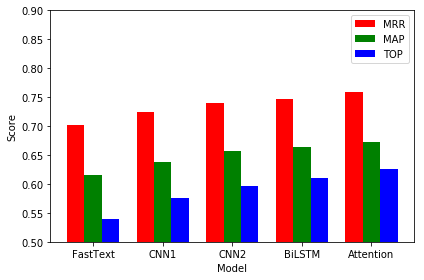

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

name_list = ['FastText', 'CNN1', 'CNN2', 'BiLSTM', 'Attention']
mrr_list = [mrr1, mrr2, mrr3, mrr4, mrr5]
map_list = [map1, map2, map3, map4, map5]
top_list = [top1, top2, top3, top4, top5]

# 设置柱状图
bar_width = 0.25
index = np.arange(len(name_list))
bar1 = plt.bar(index + bar_width * 0, mrr_list, bar_width, color='r', label='MRR')
bar2 = plt.bar(index + bar_width * 1, map_list, bar_width, color='g', label='MAP')
bar3 = plt.bar(index + bar_width * 2, top_list, bar_width, color='b', label='TOP')

plt.xlabel('Model')
plt.ylabel('Score')
plt.xticks(index + bar_width, name_list)
plt.ylim(0.5, 0.9)
plt.legend()
plt.tight_layout()
plt.savefig('img/Score3.png')
plt.show()

### 概率分布

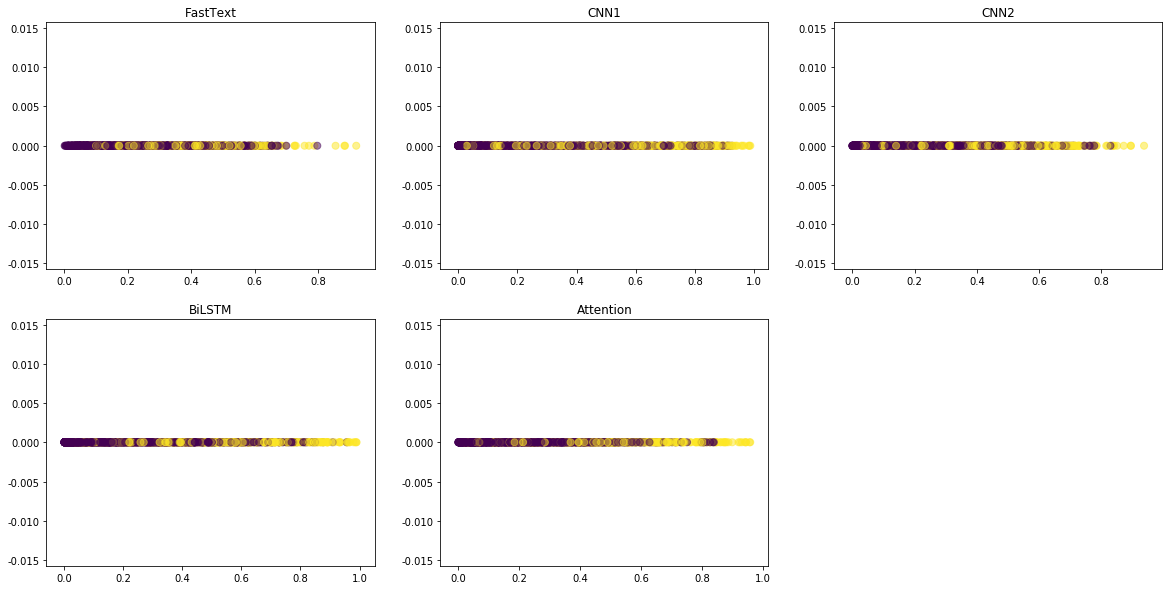

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

X1 = y1
X2 = y2
X3 = y3
X4 = y4
X5 = y5
Y = [0] * len(y_true)
T = y_true

plt.figure(figsize=(20, 10))

plt.subplot(2, 3, 1)
plt.title('FastText')
plt.scatter(X1, Y, s=50, c=T, alpha=.5)
plt.subplot(2, 3, 2)
plt.title('CNN1')
plt.scatter(X2, Y, s=50, c=T, alpha=.5)
plt.subplot(2, 3, 3)
plt.title('CNN2')
plt.scatter(X3, Y, s=50, c=T, alpha=.5)
plt.subplot(2, 3, 4)
plt.title('BiLSTM')
plt.scatter(X4, Y, s=50, c=T, alpha=.5)
plt.subplot(2, 3, 5)
plt.title('Attention')
plt.scatter(X5, Y, s=50, c=T, alpha=.5)

plt.savefig('img/Score4.png')
plt.show()